# Sensitivity maps plot

__last update__: 16/05/22

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import copy
import numpy as np
import pickle as pkl
from astropy.io import fits
from scipy.optimize import minimize
import seaborn as sns # for nicer colors on the plot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, ListedColormap, TwoSlopeNorm
from matplotlib import patches as mpatches
plt.rc('image', interpolation='none', origin='lower')
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

from herculens.Util.plot_util import nice_colorbar, nice_colorbar_residuals

In [2]:
SAVE_FIGURES = False
figure_dir = os.path.join('figures', 'sensitivity maps')

In [3]:
# types of potential perturbations we consider
scenario= 'real'
grid_scale_factor = 1
perturb_types = {
    f'{scenario}-dark_halo_newnoise': "LS", 
    f'{scenario}-GRF_newnoise': "PS", 
    f'{scenario}-discyness_newnoise': "HM"
}

# for each case, load the saved data from the modeling
sensit_map_data = {}
for perturb_type in perturb_types.keys():
    with open(os.path.join('results', f'sensimap-scale_{grid_scale_factor}-{perturb_type}-smooth_potential-smooth_source.pkl'), 'rb') as f:
        content = pkl.load(f)
        sensit_map_data[perturb_type] = content


In [4]:
def set_column_title(ax, title, fontsize=16):
    ax.text(0.5, 1.05, title, transform=ax.transAxes, 
            ha='center', va='bottom', fontsize=fontsize)
    
def set_row_title(ax, title, fontsize=16):
    #ax.text(0, 0.5, title, transform=ax.transAxes,
    #        ha='left', va='center', fontsize=fontsize)
    ax.text(-0.16, 0.5, title, transform=ax.transAxes, rotation=90,
            ha='left', va='center', fontsize=fontsize)
    
def add_scale_bar(ax, extent, pixel_size, size_arcsec=1, bar_width_pixel=1, 
                  position=None, color='white', fontsize=16):
    if position is None:
        position = (extent[0]+5*pixel_size, extent[2]+5*pixel_size)
    width, height = size_arcsec, bar_width_pixel*pixel_size
    bar = mpatches.Rectangle(position, width, height, facecolor=color)
    ax.add_patch(bar)
    text_offset_y = 2 * height
    text = '{}"'.format(size_arcsec)
    ax.text(position[0]+width/2., position[1]+text_offset_y, text, color=color, fontsize=fontsize, 
            horizontalalignment='center', verticalalignment='bottom')

def add_title_box(ax, text, fontsize=16, txt_color='white', bg_color='black'):
    ax.text(0.05, 0.95, text, color=txt_color, fontsize=fontsize, 
            horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': 0.5})
    
def add_text_box(ax, text, loc='right', fontsize=16,
                 txt_color='black', txt_alpha=1,
                 bg_color='white', bg_alpha=1):
    if loc == 'right':
        x, y = 0.95, 0.05
        ha, va = 'right', 'bottom'
    elif loc == 'left':
        x, y = 0.05, 0.05
        ha, va = 'left', 'bottom'
    elif loc == 'top left':
        x, y = 0.05, 0.95
        ha, va = 'left', 'top'
    elif loc == 'top right':
        x, y = 0.95, 0.95
        ha, va = 'right', 'top'
    ax.text(x, y, text, color=txt_color, alpha=txt_alpha, fontsize=fontsize, 
            horizontalalignment=ha, verticalalignment=va,
            transform=ax.transAxes, bbox={'color': bg_color, 'alpha': bg_alpha})
    
def add_imshow_inset(ax, image, edge_color='white', **kwargs_imshow):
    w, h = 0.35, 0.35 # relative to ax size
    ax_ins = ax.inset_axes([-0.05, 1.05-h, w, h])
    ax_ins.set_xticks([]); ax_ins.set_yticks([])
    im_ins = ax_ins.imshow(image, **kwargs_imshow)
    im_ins.set_rasterized(True)
    ax_ins.spines['bottom'].set_color(edge_color)
    ax_ins.spines['top'].set_color(edge_color)
    ax_ins.spines['left'].set_color(edge_color)
    ax_ins.spines['right'].set_color(edge_color)
    return ax_ins

=== REAL-DARK_HALO_NEWNOISE (LS) ===


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: No contour levels were found within the data range.


=== REAL-GRF_NEWNOISE (PS) ===
=== REAL-DISCYNESS_NEWNOISE (HM) ===


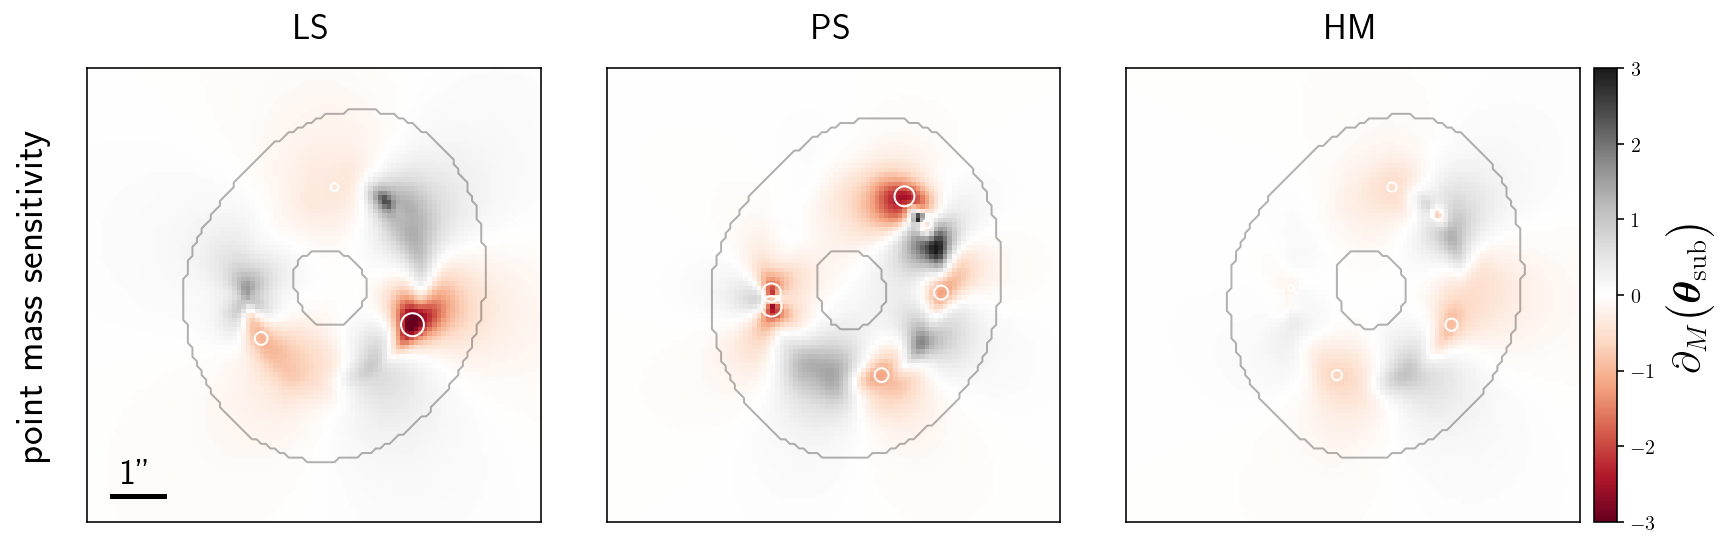

In [5]:
fontsize = 18
fontsize_row = 20
fontsize_cb = 20
cb_pad = 0.1

norm_sensit = Normalize(-3, 3)
cmap_sensit = 'RdGy'

# FIGURE LAYOUT
num_rows = 1
num_cols = len(perturb_types)
fig, axes = plt.subplots(num_rows, num_cols,
                         #gridspec_kw={'width_ratios':[0.6]+[1]*num_cols},
                         figsize=(12, 22))
if num_cols == 1:
    axes = [axes]
for i, (perturb_type, perturb_name) in enumerate(perturb_types.items()):
    print(f"=== {perturb_type.upper()} ({perturb_name}) ===")
    
    ###################
    
    # load all necessary data
    data, full_lens_image, full_kwargs_result, \
        halo_lens_image, halo_param,\
        sensitivity_map, x_minima, y_minima, z_minima,\
        = sensit_map_data[perturb_type]
    
    extent = full_lens_image.Grid.extent
    pixel_size = full_lens_image.Grid.pixel_width
    x_grid, y_grid = full_lens_image.Grid.pixel_coordinates
    x_grid_map, y_grid_map = full_lens_image.Grid.model_pixel_coordinates('sensit_map')
    extent_map = full_lens_image.Grid.model_pixel_extent('sensit_map')
    
    # SNR source arc mask
    lensed_src = full_lens_image.model(**full_kwargs_result, lens_light_add=False)
    src_snr = lensed_src / np.sqrt(full_lens_image.Noise.C_D_model(lensed_src))
    src_mask = (src_snr > 5).astype(float)
    ###################
        
    # misc
    first_col = (i == 0)
    last_col  = (i == num_cols-1)
    
    #sensitivity_map_plt = 1. / sensitivity_map
    sensitivity_map_plt = sensitivity_map
    
    # SENSITIVITY MAP
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    set_column_title(ax, f"{perturb_name}", fontsize=fontsize)
    if first_col:
        set_row_title(ax, "point mass sensitivity", fontsize=fontsize_row)
        add_scale_bar(ax, extent_map, pixel_size, size_arcsec=1,
                  color='black', fontsize=fontsize)
    im = ax.imshow(sensitivity_map_plt, extent=extent_map, norm=norm_sensit, cmap=cmap_sensit)
    im.set_rasterized(True)
    ax.contour(src_mask, extent=extent, levels=[1], colors='black', linestyles='-', linewidths=1, alpha=0.3)
    #kwargs_scatter = dict(c='white', marker='v', s=np.abs(z_minima)*4e1, 
    #                                edgecolors='#000000', linewidths=0.5, alpha=0.5)
    kwargs_scatter = dict(marker='o', s=np.abs(z_minima)*4e1, 
                          edgecolors='white', facecolors='none',
                          linewidths=1, alpha=1)
    ax.scatter(x_minima, y_minima, zorder=10, **kwargs_scatter)
    #nice_colorbar(im, pad=cb_pad,  label=r"$\partial \theta_E / \partial L$", 
    #              fontsize=fontsize_cb, invisible=not last_col)
    nice_colorbar_residuals(im, sensitivity_map_plt, norm_sensit.vmin, norm_sensit.vmax,
                            pad=cb_pad, 
                            label=r"$\partial_M\big( \boldsymbol \theta_{\rm sub} \big)$", 
                            fontsize=fontsize_cb, invisible=not last_col)
    
#fig.subplots_adjust(hspace=0.1, wspace=0)
fig.tight_layout()
plt.show()


In [6]:
if SAVE_FIGURES:
    # saving as pdf causes weird misalignments of axes, so I save in jpg
    figure_name = 'sensit_map-smooth_pot-smooth_src-summary.pdf'
    fig.savefig(os.path.join(figure_dir, figure_name), bbox_inches='tight', dpi=300)